# ⭐️ 목표 : 지하철 역을 기준으로 월별 평균 승하차합계 및 지하철 위치에 대한 정보를 담고있는 데이터 생성
- 날짜, 지하철역별, 시간대별 승하차 인원 통계 데이터와 지하철 위치 데이터를 병합하기
- 월평균승하차합계가 높은 역을 확인하기

In [31]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from glob import glob
from tqdm import tqdm
from haversine import haversine
import geopy.distance
import numpy as np
import random
import folium
from folium.features import CustomIcon
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform
try:

    if platform.system() == 'Windows':

        #윈도우인 경우

        font_name = font_manager.FontProperties(fname="c:/Windows/fonts/malgun.ttf").get_name()

        rc('font', family=font_name)

    else:

        #Mac인 경우

        rc('font', family='AppleGothic')

except:

    pass

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# %matplotlib inline

# #맥에서 한글 안깨지게
# rc('font', family='NanumGothic')

# plt.rcParams['axes.unicode_minus'] = False

In [3]:
station = pd.read_csv('/Users/nabong/Desktop/project_login/data/subway/staion_population_daily20221231.csv', encoding='cp949')
station_loc = pd.read_csv('/Users/nabong/Desktop/project_login/data/subway/seoul_subway_location_2021.csv', encoding='cp949')

/var/folders/5z/x3njjl9j3tb_1llqpqvxxqhm0000gn/T/ipykernel_1492/2221574305.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  station = pd.read_csv('/Users/nabong/Desktop/project_login/data/subway/staion_population_daily20221231.csv', encoding='cp949')


In [4]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

font_path = '/Library/Fonts/AppleSDGothicNeoUL.ttf'
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)


## ✅ 데이터 전처리

In [5]:
# 역별 승하차 데이터 구조 확인
station.info()
station.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199080 entries, 0 to 199079
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   연번            199080 non-null  int64  
 1   수송일자          199080 non-null  object 
 2   호선            199080 non-null  int64  
 3   고유역번호(외부역코드)  199080 non-null  object 
 4   역명            199080 non-null  object 
 5   승하차구분         199080 non-null  object 
 6   06시이전         199080 non-null  int64  
 7   06-07시간대      199080 non-null  int64  
 8   07-08시간대      199080 non-null  int64  
 9   08-09시간대      199080 non-null  int64  
 10  09-10시간대      199080 non-null  int64  
 11  10-11시간대      199080 non-null  int64  
 12  11-12시간대      199080 non-null  int64  
 13  12-13시간대      199080 non-null  int64  
 14  13-14시간대      199080 non-null  int64  
 15  14-15시간대      199080 non-null  int64  
 16  15-16시간대      199080 non-null  int64  
 17  16-17시간대      199080 non-null  int64  
 18  17-1

,연번,수송일자,호선,고유역번호(외부역코드),역명,승하차구분,06시이전,06-07시간대,07-08시간대,08-09시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후
0,1,2022-01-01,1,150,서울역,승차,120,137,211,439,...,1566,1686,1591,1358,1062,899,1327,814,234,NaN
1,2,2022-01-01,1,150,서울역,하차,113,560,617,910,...,1329,1251,1126,884,764,654,728,416,131,NaN


In [6]:
# 역 위치 데이터 구조 확인
station_loc.info()
station_loc.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   연번            276 non-null    int64  
 1   호선            276 non-null    int64  
 2   고유역번호(외부역코드)  276 non-null    int64  
 3   역명            276 non-null    object 
 4   위도            276 non-null    float64
 5   경도            276 non-null    float64
 6   작성일자          276 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 15.2+ KB


,연번,호선,고유역번호(외부역코드),역명,위도,경도,작성일자
0,1,1,150,서울,37.55315,126.972533,1974-02-28
1,2,1,151,시청,37.56359,126.975407,1974-08-15


In [7]:
# 필요없는 컬럼 삭제 - 연번, 작성일자
station.drop('연번', axis=1, inplace=True)
station_loc.drop(['연번', '작성일자'], axis=1, inplace=True)

In [8]:
# 데이터 타입이 object인 컬럼 중 고유역번호 데이터 확인 - 확인결과 int타입과 string 타입이 섞여있고 공백문자가 들어간 컬럼도 있음
print(station['고유역번호(외부역코드)'].unique())
print(station['고유역번호(외부역코드)'].unique().shape[0])

[150 151 152 153 154 155 156 157 158 159 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 309 310 311 312 313 314 315 316 317 318 319 320
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 2511 2512 2513 2514 2515 2516
 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527 2528 2529 2530
 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544
 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558
 2559 2560 2561 2562 2563 2564 2565 2566 2611 2612 2613 2614 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2711 2712 2713 2714 2715 2716 2717 2718 2719 

In [9]:
# 고유역코드가 비어있는 컬럼은 1개이고 광명사거리역
station[station['고유역번호(외부역코드)'] == ' ']

,수송일자,호선,고유역번호(외부역코드),역명,승하차구분,06시이전,06-07시간대,07-08시간대,08-09시간대,09-10시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후
132480,2022-08-31,7,,광명사거리,승차,801,1299,3405,3901,1843,...,965,1181,1376,1283,779,521,448,346,124,15.0


In [10]:
# 광명사거리의 고유역번호를 확인
station[station['역명'] == '광명사거리'].head(2)

,수송일자,호선,고유역번호(외부역코드),역명,승하차구분,06시이전,06-07시간대,07-08시간대,08-09시간대,09-10시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후
502,2022-01-01,7,2750,광명사거리,승차,208,208,315,417,508,...,852,866,710,589,359,408,415,176,58,NaN
503,2022-01-01,7,2750,광명사거리,하차,50,122,179,258,371,...,822,771,771,742,509,456,678,556,235,NaN


In [11]:
# 같은 7호선이며 고유역코드가 2750임이 확인되어 2750으로 대치
station['고유역번호(외부역코드)'].replace(' ', '2750', inplace=True)
station[station['고유역번호(외부역코드)'] == ' '].shape[0] # 대치가 완료되어 해당 데이터 없음

0

In [12]:
# 공통 컬럼인 고유역번호(외부역코드)의 데이터 타입이 다르므로 object를 통일하고 이름도 node_id 변경(버스정보와 합치기위해 통일)
station.rename(columns={'고유역번호(외부역코드)':'node_id', '역명':'정류소명(역명)'}, inplace=True)
station_loc.rename(columns={'고유역번호(외부역코드)':'node_id', '역명':'정류소명(역명)'}, inplace=True)

# 수송일자 컬럼의 데이터타입을 날짜로 변경하고 호선의 데이터타입을 string으로 변경)
station = station.astype({'node_id':'string', '수송일자':'datetime64', '호선':'string'})
station_loc = station_loc.astype({'node_id':'string', '호선':'string'})

# 바뀐 내용 확인
station.info()
station_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199080 entries, 0 to 199079
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   수송일자      199080 non-null  datetime64[ns]
 1   호선        199080 non-null  string        
 2   node_id   199080 non-null  string        
 3   정류소명(역명)  199080 non-null  object        
 4   승하차구분     199080 non-null  object        
 5   06시이전     199080 non-null  int64         
 6   06-07시간대  199080 non-null  int64         
 7   07-08시간대  199080 non-null  int64         
 8   08-09시간대  199080 non-null  int64         
 9   09-10시간대  199080 non-null  int64         
 10  10-11시간대  199080 non-null  int64         
 11  11-12시간대  199080 non-null  int64         
 12  12-13시간대  199080 non-null  int64         
 13  13-14시간대  199080 non-null  int64         
 14  14-15시간대  199080 non-null  int64         
 15  15-16시간대  199080 non-null  int64         
 16  16-17시간대  199080 non-null  int64      

In [13]:
# 역별 승하차 테이블이 갖고 있는 역이 위치정보를 갖고 있는지 확인
print(len(set(station['node_id'])) == len(set(station_loc['node_id']))) # 다름

False


In [14]:
# 차집합 확인
print('위치 정보가 없는 역의 번호: ', set(station['node_id']) - set(station_loc['node_id']))
no_id = station[(station['node_id'] == '2753') | (station['node_id'] == '2757') | (station['node_id'] == '2758') | (station['node_id'] == '2761')]['정류소명(역명)']
print('위치 정보가 없는 역의 이름: ', set(no_id.values))

위치 정보가 없는 역의 번호:  {'2758', '2761', '2753', '2757'}
위치 정보가 없는 역의 이름:  {'부천시청', '까치울', '부평구청', '상동'}


In [15]:
# 해당 역들은 모두 인천, 부천 소속이므로 드랍
station = station.drop(no_id.index, axis=0)

In [16]:
print('위치 정보가 없는 역의 번호: ', set(station['node_id']) - set(station_loc['node_id']))

위치 정보가 없는 역의 번호:  set()


In [17]:
# 결측치를 갖고있는 24시이후 컬럼의 경우 결측치를 0으로 채워줌
station['24시이후'].fillna(0, inplace=True)
station['24시이후'] = station['24시이후'].astype('int')

In [18]:
# 승하차 데이터 나누기
station_in = station[station['승하차구분'] == '승차'].drop('승하차구분', axis=1)
station_out = station[station['승하차구분'] == '하차'].drop('승하차구분', axis=1)

In [19]:
station_in.head(2)

,수송일자,호선,node_id,정류소명(역명),06시이전,06-07시간대,07-08시간대,08-09시간대,09-10시간대,10-11시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후
0,2022-01-01,1,150,서울역,120,137,211,439,592,878,...,1566,1686,1591,1358,1062,899,1327,814,234,0
2,2022-01-01,1,151,시청,38,66,101,139,121,137,...,474,550,672,528,420,434,491,232,38,0


In [20]:
# 승하차 테이블에 일일 합계를 위한 '합계' 컬럼 추가
station_in['합계'] = station_in.iloc[:, 4:].sum(axis=1)
station_out['합계'] = station_out.iloc[:, 4:].sum(axis=1)

In [21]:
station_out.head(2)

,수송일자,호선,node_id,정류소명(역명),06시이전,06-07시간대,07-08시간대,08-09시간대,09-10시간대,10-11시간대,...,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후,합계
1,2022-01-01,1,150,서울역,113,560,617,910,1232,1260,...,1251,1126,884,764,654,728,416,131,0,17087
3,2022-01-01,1,151,시청,31,195,224,380,283,309,...,377,354,213,131,98,137,61,24,0,5063


In [22]:
# 승하차 1년 총 합계
sum_in = pd.DataFrame(station_in.groupby(['node_id', '정류소명(역명)'])['합계'].sum()).reset_index()
sum_out = pd.DataFrame(station_out.groupby(['node_id', '정류소명(역명)'])['합계'].sum()).reset_index()

# 합계를 12로 나누고 월평균승차합계로 컬럼명을 바꾸기
sum_in['월평균승차수'] = round(sum_in['합계']/12, 2)
sum_in.drop('합계', axis=1, inplace=True)
sum_out['월평균하차수'] = round(sum_out['합계']/12, 2)
sum_out.drop('합계', axis=1, inplace=True)

# 승하차 정보를 모두 담은 하나의 테이블로 병합
sum_total = pd.merge(sum_in, sum_out, on=['node_id', '정류소명(역명)'])
# 월평균승하차총합계 컬럼생성
sum_total['월평균승하차총계'] = sum_total['월평균승차수'] + sum_total['월평균하차수']
sum_total

,node_id,정류소명(역명),월평균승차수,월평균하차수,월평균승하차총계
0,150,서울역,1301736.50,1264329.75,2566066.25
1,151,시청,625330.50,632575.33,1257905.83
2,152,종각,945011.25,914613.92,1859625.17
3,153,종로3가,727878.00,665596.33,1393474.33
4,154,종로5가,628529.42,624630.50,1253159.92
...,...,...,...,...,...
270,430,이촌(국립중앙박물관),246369.92,270050.33,516420.25
271,431,동작(현충원),55985.33,65523.33,121508.66
272,432,총신대입구(이수),520579.33,566208.00,1086787.33
273,433,사당,730378.25,628545.25,1358923.50


In [23]:
# 승하차 집계 테이블 + 위치 테이블 병합
result = pd.merge(sum_total, station_loc[['node_id', '위도', '경도']], on='node_id')

# 서울이 아닌 지역의 데이터가 있는지 확인
# 서울의 범위 : 위도 (37.413294 ~ 37.715133) / 경도(126.734086 ~ 127.269311)
result[(result['위도'] < 37.413294) | (result['위도'] > 37.715133) | (result['경도'] < 126.734086) | (result['경도'] > 127.269311)] # 없음

,node_id,정류소명(역명),월평균승차수,월평균하차수,월평균승하차총계,위도,경도


In [24]:
result['node_id'] = 'S' + result['node_id']

In [25]:
result.info()
result.head()
result.to_excel('subway_info.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 0 to 274
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   node_id   275 non-null    string 
 1   정류소명(역명)  275 non-null    object 
 2   월평균승차수    275 non-null    float64
 3   월평균하차수    275 non-null    float64
 4   월평균승하차총계  275 non-null    float64
 5   위도        275 non-null    float64
 6   경도        275 non-null    float64
dtypes: float64(5), object(1), string(1)
memory usage: 17.2+ KB


## ✅ 시각화

/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current fo

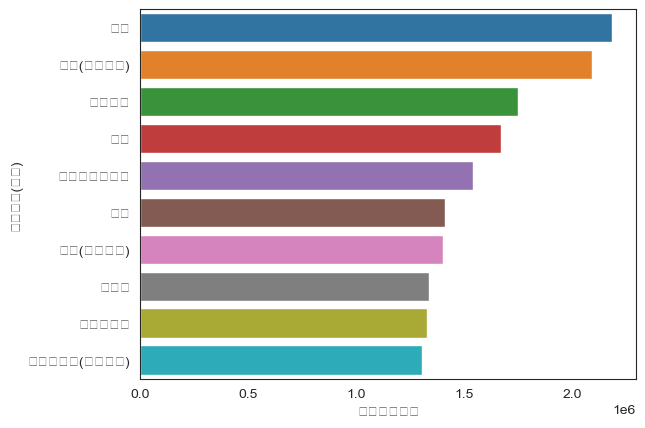

/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.

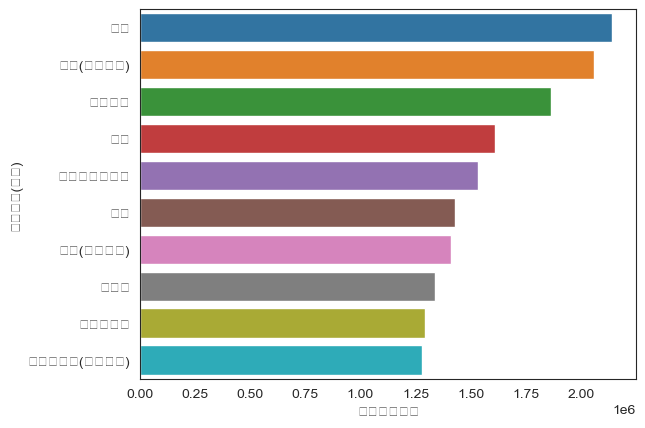

/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nabong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current fo

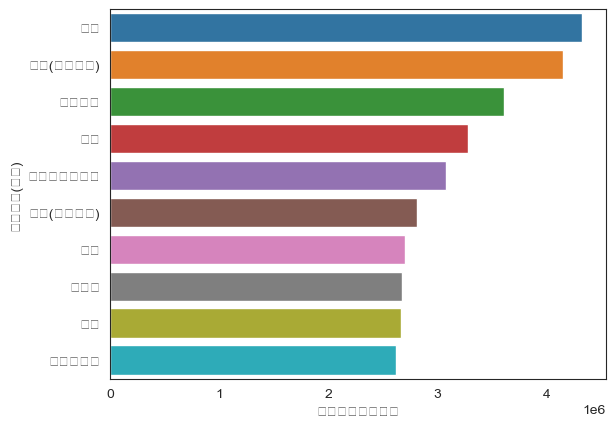

In [32]:
# 승차 인원 수가 많은 역 TOP10
sns.set_style('white')
sns.color_palette("rocket", as_cmap=True)
in_top10 = result.sort_values(by='월평균승차수', ascending=False).head(10)
sns.barplot(x='월평균승차수', y='정류소명(역명)', data=in_top10)
plt.show()

# 하차 인원 수가 많은 역 TOP10
out_top10 = result.sort_values(by='월평균하차수', ascending=False).head(10)
sns.barplot(x='월평균하차수', y='정류소명(역명)', data=out_top10)
plt.show()

# 승하차 총계가 많은 역 TOP10
total_top10 = result.sort_values(by='월평균승하차총계', ascending=False).head(10)
sns.barplot(x='월평균승하차총계', y='정류소명(역명)', data=total_top10)
plt.show()